<a href="https://colab.research.google.com/github/inci-bakimci/agProgramlama/blob/main/MarketAnalizi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Veriye genel bir bakış sağlamak için bir foksiyon oluşturduk
def check_df(df):
    print("##################### Verimizi Görelim #####################")
    print(df.head())
    print("##################### Boyut bilgisi #####################")
    print(df.shape)
    print("##################### Verimizin bilgileri #####################")
    print(df.info())
    print("##################### Eksik değer bilgisi #####################")
    print(df.isnull().sum())
    print("##################### Sayısal Değişkenlerin matematiksel oranları #####################")
    print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##################### Verimizi Görelim #####################
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
##################### Boyut bilgisi #####################
(541909, 8)
##################### Verimizin bilgileri ################

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#Ürünlerden kaçar tane satıldığı bilgisi (Information on how many of the products were sold)
df["Description"].value_counts().head(100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
                                      ... 
DOORMAT RED RETROSPOT                  707
LUNCH BAG DOLLY GIRL DESIGN            706
JUMBO BAG SPACEBOY DESIGN              702
SET OF 3 HEART COOKIE CUTTERS          700
WOOD BLACK BOARD ANT WHITE FINISH      698
Name: count, Length: 100, dtype: int64

In [ ]:
df['Country'].value_counts()

In [ ]:
#Kaç benzersiz ürün var
df["Description"].nunique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4223

In [ ]:
def outlier_thresholds(df, variable):
    quartile1 = df[variable].quantile(0.01)
    quartile3 = df[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(df, variable):
    low_limit, up_limit = outlier_thresholds(df, variable)
    df.loc[(df[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")

df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,mean,min,0%,5%,50%,95%,99%,100%,max,std
Quantity,541909.0,8.519687,-80995.0,-80995.0,1.0,3.0,29.0,100.0,253.0,253.0,154.626855
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-13 09:35:00,2011-07-19 17:17:00,2011-11-30 14:41:00,2011-12-08 09:28:00,2011-12-09 12:50:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,3.327278,-11062.06,-11062.06,0.42,2.08,9.95,18.0,44.715,44.715,21.652615
CustomerID,406829.0,15287.69057,12346.0,12346.0,12626.0,15152.0,17905.0,18212.0,18287.0,18287.0,1713.600303


In [ ]:
###################################   Veri Önişleme    #######################################

# Sütunlardaki na değerlerden kurtulduk
# Description içinde string değerleri ayırdık.
# İade işlemlerini temsil eden C karakteri ile iade işlemlerinden kurtulduk.
# StockCode içerisinde numeric olmayan değerleri eledik.
# Quantity değerinin 0'dan küçük değerlerini eledik.

df.dropna(axis=0, inplace=True)
df["Description"] = df["Description"].str.strip(" ")
df = df[~df["InvoiceNo"].str.contains("C", na=False)]
df = df[df["StockCode"].apply(lambda x: str(x).isnumeric())]
df = df[df["Quantity"] > 0]
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom


In [ ]:
basket = (df[df["Country"] == "Germany"]
              .groupby(["InvoiceNo", "Description"])["Quantity"]
              .sum().unstack().fillna(0)
              .applymap(lambda x: 1 if x > 0 else 0))
basket.iloc[0:5, 0:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND
InvoiceNo,,,,,
536527,0,0,0,0,0
536840,0,0,0,0,0
536861,0,0,0,0,0
536983,0,0,0,0,0
537197,0,0,0,0,0


In [ ]:
# support değerimiz için bir eşik belirledik.
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
# ürünlerin elde ettiğimiz supportlarının ilk 5 değerine baktık.
frequent_itemsets.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.024943,(10 COLOUR SPACEBOY PEN)
1,0.022676,(12 PENCIL SMALL TUBE WOODLAND)
2,0.020408,(12 PENCILS TALL TUBE WOODLAND)
3,0.034014,(3 HOOK HANGER MAGIC GARDEN)
4,0.043084,(3 PIECE SPACEBOY COOKIE CUTTER SET)


In [ ]:
# support, confidence ve lift ile ilgili kuralları oluşturduk.
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


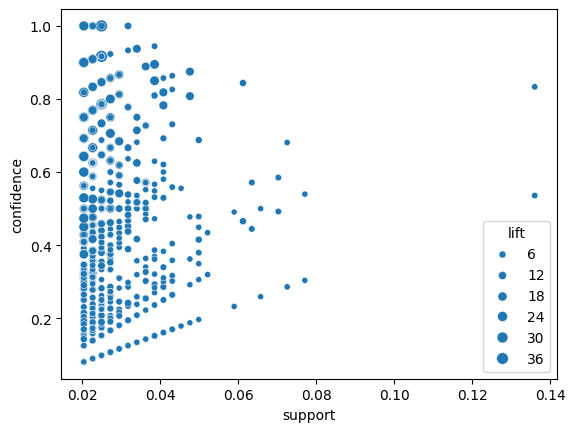

In [ ]:
# support ve confidence kullanarak dağılım grafiği oluşturduk
sns.scatterplot(x = "support", y = "confidence",
                size = "lift", data = rules)
plt.show()

In [ ]:
rules.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ROUND SNACK BOXES SET OF4 WOODLAND),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.253968,0.043084,0.022676,0.089286,2.072368,0.011734,1.050731,0.693617
1,(3 PIECE SPACEBOY COOKIE CUTTER SET),(ROUND SNACK BOXES SET OF4 WOODLAND),0.043084,0.253968,0.022676,0.526316,2.072368,0.011734,1.574956,0.540758
2,(BLUE HARMONICA IN BOX),(6 RIBBONS RUSTIC CHARM),0.049887,0.106576,0.020408,0.409091,3.838491,0.015091,1.511948,0.778308
3,(6 RIBBONS RUSTIC CHARM),(BLUE HARMONICA IN BOX),0.106576,0.049887,0.020408,0.191489,3.838491,0.015091,1.175140,0.827693
4,(6 RIBBONS RUSTIC CHARM),(CHARLOTTE BAG APPLES DESIGN),0.106576,0.068027,0.020408,0.191489,2.814894,0.013158,1.152703,0.721658


Vardığımız sonucu örnekle yorumlayacak olursak:

6 RIBBONS RUSTIC CHARM ve REGENCY CAKESTAND 3 TIER ürünlerinin birlikte alınma oranı 0.022, 3 PIECE SPACEBOY COOKIE CUTTER SET alan müşterilerin %52'si REGENCY CAKESTAND 3'te almaktadır ve 3 PIECE SPACEBOY COOKIE CUTTER SET alındığında REGENCY CAKESTAND 3 alınma oranı 2.07 kat artmaktadır.

BLUE HARMONICA IN BOX ve 6 RIBBONS RUSTIC CHARM ürünlerinin birlikte alınma oranları 0.106, BLUE HARMONICA IN BOX alan müşterilerin %40'ı 6 RIBBONS RUSTIC CHARM'da almaktadır ve BLUE HARMONICA IN BOX alındığında 6 RIBBONS RUSTIC CHARM'ın alınma oranı 3.83 kat artmaktadır.